# Collaborative Filtering algorithm

Collaborative Filtering (CF) algorithm uses a sparse rating matrix $A \in \mathcal{R}^{m\times n}$ with non-empty entries denoting ratings of items i (0<=i<n) provided by users j (0<=j<m).
CF simultaneously optimizes feature vectors $\u_j \in R^k$ of every user and $\v_i \in R^k$ of every item from the training set so that the CF loss function is minimized:
$$
\mathcal{L}^{CF}=\sum_{i,j: \exists A[j, i]} (u^t_j*v_i - A_{j,i})^2
$$

## Load data

In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

VAL_SIZE = 0.05
MAX_EPOCHS = 10
LR = 0.001
BATCH_SIZE = 10000
EMB_DIM = 1024

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!mkdir -p movielens

In [3]:
!test -e movielens/ml-1m.zip || (wget -O movielens/ml-1m.zip https://files.grouplens.org/datasets/movielens/ml-1m.zip && unzip movielens/ml-1m.zip -d movielens)

# CF for Movielens 1M dataset

In [4]:
def load_ratings(fname):
    if fname.endswith('dat'):
        df_ratings_small = pd.read_csv(fname, names=['userId','movieId','rating','timestamp'], sep='::')
    else:
        df_ratings_small = pd.read_csv(fname)
    movie_id_map = df_ratings_small.movieId.sort_values().unique()
    movie_id_map = dict(zip(movie_id_map, range(len(movie_id_map))))
    df_ratings_small['movie_emb_idx'] = df_ratings_small.movieId.map(movie_id_map)
    df_ratings_small['user_emb_idx'] = df_ratings_small.userId - 1
    df_ratings_small['rating_cent'] = df_ratings_small.rating - df_ratings_small.rating.median()
    return df_ratings_small


df_ratings = load_ratings('movielens/ml-1m/ratings.dat')

/tmp/ipykernel_15707/4245508241.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_ratings_small = pd.read_csv(fname, names=['userId','movieId','rating','timestamp'], sep='::')


In [5]:
def gen_datasets(df, train_size):
    df_train, df_val = np.array_split(df.sample(frac=1., random_state=42), [int(len(df) * train_size)])
    ds_train = torch.utils.data.dataset.TensorDataset(torch.as_tensor(df_train[['user_emb_idx', 'movie_emb_idx']].values).to(DEVICE),
                                                      torch.as_tensor(df_train['rating_cent'].values).to(DEVICE))
    ds_val = torch.utils.data.dataset.TensorDataset(torch.as_tensor(df_val[['user_emb_idx', 'movie_emb_idx']].values).to(DEVICE),
                                                      torch.as_tensor(df_val['rating_cent'].values).to(DEVICE))
    return ds_train, ds_val

ds_train, ds_val = gen_datasets(df_ratings, train_size=1 - VAL_SIZE)

In [6]:
class CFModel(torch.nn.Module):
    def __init__(self, movies_size, users_size, emb_dim):
        super().__init__()
        self.user_emb = torch.nn.Parameter(torch.randn(users_size, emb_dim) / np.sqrt(emb_dim))
        self.movie_emb = torch.nn.Parameter(torch.randn(movies_size, emb_dim) / np.sqrt(emb_dim))
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, emb_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(emb_dim, emb_dim),
            torch.nn.Tanh()
        )

    def forward(self, movie_ids, user_ids):
        user_embs = self.user_emb[user_ids]
        movie_embs = self.movie_emb[movie_ids]
        return (user_embs * movie_embs).sum(dim=-1)

CFModel(2, 2, 4).forward([1], [1])

tensor([0.7129], grad_fn=<SumBackward1>)

In [7]:
def evaluate(model, ds_val):
    with torch.no_grad():
        losses = []
        predictions = []
        for b, ratings in torch.utils.data.DataLoader(ds_val, batch_size=8192):
            user_ids = b[:, 0]
            movie_ids = b[:, 1]
            pred = model.forward(movie_ids, user_ids)
            loss = ((pred - ratings) ** 2).mean()
            losses.append(loss.item())
            predictions.append(pred)
        loss = np.sqrt(np.mean(losses).item())
        return loss, torch.concat(predictions)

In [8]:
def train(ds_train, ds_val, max_epochs, lr, batch_size):
    ds = torch.concat([ds_train.tensors[0], ds_val.tensors[0]])
    max_user_id, max_movie_id = ds.max(dim=0).values
    print(max_user_id, max_movie_id)
    model = CFModel(
        max_movie_id + 1,
        max_user_id + 1,
        EMB_DIM
    ).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    progress = tqdm(range(max_epochs))
    losses = []
    for epoch in progress:
        batches = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
        if len(ds_train) > batch_size:
            batches = tqdm(batches)
        for b, ratings in batches:
            user_ids = b[:, 0]
            movie_ids = b[:, 1]

            optim.zero_grad()
            pred = model.forward(movie_ids, user_ids)
            loss = ((pred - ratings.to(DEVICE)) ** 2).mean()
            loss.backward()
            optim.step()

        loss = evaluate(model, ds_val)[0]
        losses.append(loss)
        progress.set_description(f'Val loss:{loss:.03f}')

    fig = plt.figure(figsize=(12, 5))
    plt.plot(losses)
    print(fig.axes)
    ax = fig.axes[0]
    ax.set_title("Validation RMSE loss per training epoch")
    avg = torch.std(ds_val.tensors[1]).cpu().item()
    ax.axhline(avg, color='red')
    ax.annotate('Average score baseline', xy=(0, avg))
    return model


tensor(6039, device='cuda:0') tensor(3705, device='cuda:0')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

[<AxesSubplot:>]


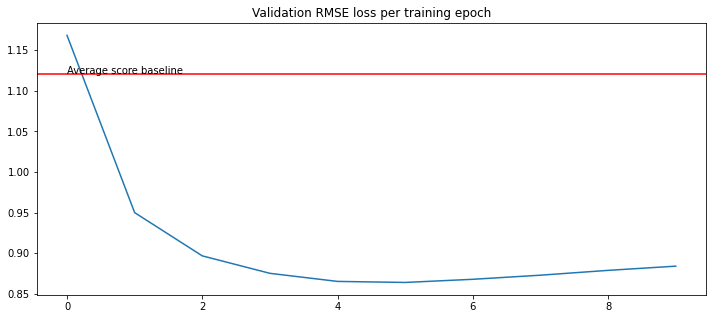

In [9]:
testmodel = train(ds_train, ds_val, max_epochs=MAX_EPOCHS, lr=LR, batch_size=BATCH_SIZE)